In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/viktor/mlfs-book-a-version
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 
secrets = hopsworks.get_secrets_api()

"""location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']"""

2025-11-18 22:29:48,113 INFO: Initializing external client
2025-11-18 22:29:48,114 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 22:29:49,487 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296538


'location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value\nlocation = json.loads(location_str)\ncountry=location[\'country\']\ncity=location[\'city\']\nstreet=location[\'street\']'

In [4]:
# Retrieve feature groups
"""air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)"""

"air_quality_fg = fs.get_feature_group(\n    name='air_quality',\n    version=1,\n)\nweather_fg = fs.get_feature_group(\n    name='weather',\n    version=1,\n)"

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
#selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [6]:
"""feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)"""

'feature_view = fs.get_or_create_feature_view(\n    name=\'air_quality_fv\',\n    description="weather features with air quality as the target",\n    version=1,\n    labels=[\'pm25\'],\n    query=selected_features,\n)'

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [7]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
"""X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)"""

'X_train, X_test, y_train, y_test = feature_view.train_test_split(\n    test_start=test_start\n)'

In [9]:
#X_train

In [10]:
"""X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])"""

"X_features = X_train.drop(columns=['date'])\nX_test_features = X_test.drop(columns=['date'])"

In [11]:
#y_train

The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [12]:
# Creating an instance of the XGBoost Regressor
"""xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)"""


'xgb_regressor = XGBRegressor()\n\n# Fitting the XGBoost Regressor to the training data\nxgb_regressor.fit(X_features, y_train)'

In [13]:
# Predicting target values on the test set
"""y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)"""

'y_pred = xgb_regressor.predict(X_test_features)\n\n# Calculating Mean Squared Error (MSE) using sklearn\nmse = mean_squared_error(y_test.iloc[:,0], y_pred)\nprint("MSE:", mse)\n\n# Calculating R squared using sklearn\nr2 = r2_score(y_test.iloc[:,0], y_pred)\nprint("R squared:", r2)'

In [14]:
"""df = y_test.copy()
df['predicted_pm25'] = y_pred"""

"df = y_test.copy()\ndf['predicted_pm25'] = y_pred"

In [15]:
"""df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)"""

"df['date'] = X_test['date']\ndf = df.sort_values(by=['date'])\ndf.head(5)"

In [16]:
# Creating a directory for the model artifacts if it doesn't exist
"""model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)"""

'model_dir = "air_quality_model"\nif not os.path.exists(model_dir):\n    os.mkdir(model_dir)\nimages_dir = model_dir + "/images"\nif not os.path.exists(images_dir):\n    os.mkdir(images_dir)'

In [17]:
"""file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()"""

'file_path = images_dir + "/pm25_hindcast.png"\nplt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) \nplt.show()'

In [18]:
# Plotting feature importances using the plot_importance function from XGBoost
"""plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()"""

'plot_importance(xgb_regressor)\nfeature_importance_path = images_dir + "/feature_importance.png"\nplt.savefig(feature_importance_path)\nplt.show()'

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [19]:
# Saving the XGBoost regressor object as a json file in the model directory
#xgb_regressor.save_model(model_dir + "/model.json")

In [20]:
"""res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }"""

'res_dict = { \n        "MSE": str(mse),\n        "R squared": str(r2),\n    }'

In [21]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

#commented this part out and put it on the bottom as to include the more detailed metrics which we only compute later!
"""aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)"""

'aq_model = mr.python.create_model(\n    name="air_quality_xgboost_model", \n    metrics= res_dict,\n    feature_view=feature_view,\n    description="Air Quality (PM2.5) predictor",\n)\n\n# Saving the model artifacts to the \'air_quality_model\' directory in the model registry\naq_model.save(model_dir)'

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.


In [22]:
#Adding code for the C-part:

""""air_quality_fg_v2 = fs.get_feature_group(
    name='air_quality',
    version=2,
)

selected_features_lag = air_quality_fg_v2.select(['pm25', 'date', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']).join(weather_fg.select_features(), on=['city'])

feature_view_lag = fs.get_or_create_feature_view(
    name='air_quality_fv_lag',
    description="weather + pm25 lag1/2/3 with pm25 as target",
    version=1,
    labels=['pm25'],
    query=selected_features_lag,
)

X_train_lag, X_test_lag, y_train_lag, y_test_lag = feature_view_lag.train_test_split(
    test_start=test_start
)

X_train_lag"""

'"air_quality_fg_v2 = fs.get_feature_group(\n    name=\'air_quality\',\n    version=2,\n)\n\nselected_features_lag = air_quality_fg_v2.select([\'pm25\', \'date\', \'pm25_lag1\', \'pm25_lag2\', \'pm25_lag3\']).join(weather_fg.select_features(), on=[\'city\'])\n\nfeature_view_lag = fs.get_or_create_feature_view(\n    name=\'air_quality_fv_lag\',\n    description="weather + pm25 lag1/2/3 with pm25 as target",\n    version=1,\n    labels=[\'pm25\'],\n    query=selected_features_lag,\n)\n\nX_train_lag, X_test_lag, y_train_lag, y_test_lag = feature_view_lag.train_test_split(\n    test_start=test_start\n)\n\nX_train_lag'

In [23]:
"""X_train_lag_features = X_train_lag.drop(columns=['date'])
X_test_lag_features = X_test_lag.drop(columns=['date'])
y_train_lag"""

"X_train_lag_features = X_train_lag.drop(columns=['date'])\nX_test_lag_features = X_test_lag.drop(columns=['date'])\ny_train_lag"

In [24]:
#Modeling:
"""xgb_regressor_lag = XGBRegressor()
xgb_regressor_lag.fit(X_train_lag_features, y_train_lag)

y_pred_lag = xgb_regressor_lag.predict(X_test_lag_features)

mse_lag = mean_squared_error(y_test_lag.iloc[:,0], y_pred_lag)
print("Lag model MSE:", mse_lag)

r2_lag = r2_score(y_test_lag.iloc[:,0], y_pred_lag)
print("Lag model R squared:", r2_lag)"""

'xgb_regressor_lag = XGBRegressor()\nxgb_regressor_lag.fit(X_train_lag_features, y_train_lag)\n\ny_pred_lag = xgb_regressor_lag.predict(X_test_lag_features)\n\nmse_lag = mean_squared_error(y_test_lag.iloc[:,0], y_pred_lag)\nprint("Lag model MSE:", mse_lag)\n\nr2_lag = r2_score(y_test_lag.iloc[:,0], y_pred_lag)\nprint("Lag model R squared:", r2_lag)'

In [25]:
#Now we need to evaluate!!!
"""df_test = X_test_lag.copy()

df_test["pm25"] = y_test_lag["pm25"].values
df_test["date"] = pd.to_datetime(df_test["date"])  #In case we dont have correct date format already!

df_test = df_test.sort_values("date").reset_index(drop=True) #Want to remove possible weird old indexes.
df_test.head()"""


'df_test = X_test_lag.copy()\n\ndf_test["pm25"] = y_test_lag["pm25"].values\ndf_test["date"] = pd.to_datetime(df_test["date"])  #In case we dont have correct date format already!\n\ndf_test = df_test.sort_values("date").reset_index(drop=True) #Want to remove possible weird old indexes.\ndf_test.head()'

In [26]:
#baseline_feature_cols = list(X_features.columns)         
#lag_feature_cols = list(X_train_lag_features.columns)

In [27]:
#we have to actually make prediction:
def forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags):
    predictions = []
    
    if use_lags: #establish a starting point (today!): 
        lag_1 = row_today['pm25']
        lag_2 = row_today['pm25_lag1']
        lag_3 = row_today['pm25_lag2']
        
    for h in range(max_horizon): #from tomorrow onwards: 
        row_to_predict = rows_to_predict.iloc[h].copy()
        
        if use_lags: #overwrite possible real values (which is illegal to use here) with predicted values!
            row_to_predict['pm25_lag1'] = lag_1
            row_to_predict['pm25_lag2'] = lag_2
            row_to_predict['pm25_lag3'] = lag_3
            
        X_row = row_to_predict[feature_cols].values.reshape(1, -1)
        y_pred = float(model.predict(X_row)[0])

        predictions.append(y_pred)
        if use_lags:
            #push all lags back because we move forward one day:
            lag_3 = lag_2 
            lag_2 = lag_1
            lag_1 = y_pred

        
    return predictions

# Compute MSE1,...,MSE7:
def hindcast_recursive(df, model, feature_cols, max_horizon=7, use_lags=False):
    target_col="pm25"
    df = df.sort_values("date").reset_index(drop=True)
    
    records= []
    
    for start_index in range(len(df) - max_horizon): #we dont want to 
        row_today = df.iloc[start_index].copy()
        rows_to_predict = df.iloc[start_index+1:start_index+1+max_horizon].copy()
        
        y_predictions = forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags)

        #unpack all:
        for i in range(max_horizon):
            y_pred = y_predictions[i]
            target_row = rows_to_predict.iloc[i]
            y_true = float(target_row[target_col])

            records.append({
                "forecast_start_date": row_today['date'],
                "target_date": target_row['date'],
                "horizon": i+1,
                "y_true": y_true,
                "y_pred": y_pred,
            })


    return pd.DataFrame(records)

In [28]:
#first we have the baseline: 
"""hc_base = hindcast_recursive(
    df_test,
    model=xgb_regressor,
    feature_cols=baseline_feature_cols,
    max_horizon=7,
    use_lags=False,
)
#then the model with lag.
hc_lag = hindcast_recursive(
    df_test,
    model=xgb_regressor_lag,
    feature_cols=lag_feature_cols,
    max_horizon=7,
    use_lags=True,
)
def mse(group):
    return mean_squared_error(group.y_true, group.y_pred)
    
def mse_per_horizon(hc_df):

    return hc_df.groupby("horizon").apply(mse)

mse_base_h = mse_per_horizon(hc_base)
mse_lag_h = mse_per_horizon(hc_lag)

comparison = pd.DataFrame({
    "mse_baseline": mse_base_h,
    "mse_lag": mse_lag_h
})

comparison"""


'hc_base = hindcast_recursive(\n    df_test,\n    model=xgb_regressor,\n    feature_cols=baseline_feature_cols,\n    max_horizon=7,\n    use_lags=False,\n)\n#then the model with lag.\nhc_lag = hindcast_recursive(\n    df_test,\n    model=xgb_regressor_lag,\n    feature_cols=lag_feature_cols,\n    max_horizon=7,\n    use_lags=True,\n)\ndef mse(group):\n    return mean_squared_error(group.y_true, group.y_pred)\n    \ndef mse_per_horizon(hc_df):\n\n    return hc_df.groupby("horizon").apply(mse)\n\nmse_base_h = mse_per_horizon(hc_base)\nmse_lag_h = mse_per_horizon(hc_lag)\n\ncomparison = pd.DataFrame({\n    "mse_baseline": mse_base_h,\n    "mse_lag": mse_lag_h\n})\n\ncomparison'

In [29]:
#Now we need to save the model
"""res_dict_lag  = { 
        "MSE": str(mse_lag),
        "R squared": str(r2_lag),
    }

#per horizon:
for h, mse in mse_lag_h.items():
    res_dict_lag[f"MSE_h{h}"] = str(mse)

res_dict_lag"""

'res_dict_lag  = { \n        "MSE": str(mse_lag),\n        "R squared": str(r2_lag),\n    }\n\n#per horizon:\nfor h, mse in mse_lag_h.items():\n    res_dict_lag[f"MSE_h{h}"] = str(mse)\n\nres_dict_lag'

In [30]:
"""res_dict_base  = res_dict.copy()

for h, mse in mse_base_h.items():
    res_dict_base[f"MSE_h{h}"] = str(mse)

res_dict_base"""


'res_dict_base  = res_dict.copy()\n\nfor h, mse in mse_base_h.items():\n    res_dict_base[f"MSE_h{h}"] = str(mse)\n\nres_dict_base'

In [31]:
"""model_dir_lag = "air_quality_model_lag"
if not os.path.exists(model_dir_lag):
    os.mkdir(model_dir_lag)
images_dir = model_dir_lag + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)"""



'model_dir_lag = "air_quality_model_lag"\nif not os.path.exists(model_dir_lag):\n    os.mkdir(model_dir_lag)\nimages_dir = model_dir_lag + "/images"\nif not os.path.exists(images_dir):\n    os.mkdir(images_dir)'

In [32]:
#Images and stuff (replicating what exist for the base model):
"""df_lag = y_test_lag.copy()
df_lag['predicted_pm25'] = y_pred_lag    #This is only for a day ahead predictions i belive!

df_lag['date'] = X_test_lag['date']
df_lag = df_lag.sort_values(by=['date'])
df_lag.head(5)"""

"df_lag = y_test_lag.copy()\ndf_lag['predicted_pm25'] = y_pred_lag    #This is only for a day ahead predictions i belive!\n\ndf_lag['date'] = X_test_lag['date']\ndf_lag = df_lag.sort_values(by=['date'])\ndf_lag.head(5)"

In [33]:
"""file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df_lag, file_path, hindcast=True) 
plt.show()"""


'file_path = images_dir + "/pm25_hindcast.png"\nplt = util.plot_air_quality_forecast(city, street, df_lag, file_path, hindcast=True) \nplt.show()'

In [34]:
# Plotting feature importances using the plot_importance function from XGBoost
"""plot_importance(xgb_regressor_lag)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()"""

'plot_importance(xgb_regressor_lag)\nfeature_importance_path = images_dir + "/feature_importance.png"\nplt.savefig(feature_importance_path)\nplt.show()'

In [35]:
# Saving the XGBoost regressor object as a json file in the model directory
"""xgb_regressor_lag.save_model(model_dir_lag + "/model.json")

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model_lag = mr.python.create_model(
    name="air_quality_xgboost_model_lag", 
    metrics= res_dict_lag,
    feature_view=feature_view_lag,
    description="Air Quality (PM2.5) predictor with lag pm25 values",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model_lag.save(model_dir_lag)"""

'xgb_regressor_lag.save_model(model_dir_lag + "/model.json")\n\n# Creating a Python model in the model registry named \'air_quality_xgboost_model\'\n\naq_model_lag = mr.python.create_model(\n    name="air_quality_xgboost_model_lag", \n    metrics= res_dict_lag,\n    feature_view=feature_view_lag,\n    description="Air Quality (PM2.5) predictor with lag pm25 values",\n)\n\n# Saving the model artifacts to the \'air_quality_model\' directory in the model registry\naq_model_lag.save(model_dir_lag)'

In [36]:
#Now we want to add the evaluation data for the base model aswell:

"""aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_base", 
    metrics= res_dict_base,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor (upgraded metrics)",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)"""


'aq_model = mr.python.create_model(\n    name="air_quality_xgboost_model_base", \n    metrics= res_dict_base,\n    feature_view=feature_view,\n    description="Air Quality (PM2.5) predictor (upgraded metrics)",\n)\n\n# Saving the model artifacts to the \'air_quality_model\' directory in the model registry\naq_model.save(model_dir)'

In [37]:
#A - part

"""project = hopsworks.login()
fs = project.get_feature_store() 
secrets = hopsworks.get_secrets_api()"""
#today = datetime.date.today()

# This line will fail if you have not registered the AQICN_API_KEY as a secret in Hopsworks
AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value


In [38]:
def train_model(country, city, street, aqicn_url):
    air_quality_fg_v2 = fs.get_feature_group(
        name='air_quality',
        version=3,
    )
    weather_fg = fs.get_feature_group(
        name='weather',
        version=3,
    )
    """air_quality_fg_v2 = air_quality_fg_v2.filter(air_quality_fg_v2["street"] == street)  #We have multiple sensors in the city. street is unique. 

    #This may blow up but should be fine:
    selected_features_lag = air_quality_fg_v2.select(['pm25', 'date', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']).join(weather_fg.select_features(), on=['city', 'date'])
    """
    aq_query = air_quality_fg_v2.select(["pm25", "date", "pm25_lag1", "pm25_lag2", "pm25_lag3"]).filter(air_quality_fg_v2["street"] == street)
    
    selected_features_lag = aq_query.join(weather_fg.select_features(), on=["city"])
    
    street_safe = street.replace(" ", "_").lower()
    name = f"air_quality_fv_lag_{street_safe}"
    
    feature_view_lag = fs.get_or_create_feature_view(
        #name='air_quality_fv_lag',
        name = name,
        description="weather + pm25 lag1/2/3 with pm25 as target",
        version=3,
        labels=['pm25'],
        query=selected_features_lag,
    )

    X_train_lag, X_test_lag, y_train_lag, y_test_lag = feature_view_lag.train_test_split(
        test_start=test_start
    )
    print("Look if X_train_lag matches y_train_lag: ")
    print(X_train_lag)
    #perhaps i need to sort here to really ensure that it works. but maybe not. The maping to y_train_lag could be sufficient.
    X_train_lag_features = X_train_lag.drop(columns=['date'])
    X_test_lag_features = X_test_lag.drop(columns=['date'])
    print(y_train_lag)

    #Modeling:
    xgb_regressor_lag = XGBRegressor()
    xgb_regressor_lag.fit(X_train_lag_features, y_train_lag)
    
    y_pred_lag = xgb_regressor_lag.predict(X_test_lag_features)
    
    mse_lag = mean_squared_error(y_test_lag.iloc[:,0], y_pred_lag)
    print("Lag model MSE:", mse_lag)
    
    r2_lag = r2_score(y_test_lag.iloc[:,0], y_pred_lag)
    print("Lag model R squared:", r2_lag)

    #Now we need to evaluate for each horizon!!!
    df_test = X_test_lag.copy()
    df_test["pm25"] = y_test_lag["pm25"].values
    df_test["date"] = pd.to_datetime(df_test["date"])  #In case we dont have correct date format already!
    df_test = df_test.sort_values("date").reset_index(drop=True) #Want to remove possible weird old indexes.
    print(df_test.head())
         
    lag_feature_cols = list(X_train_lag_features.columns)
    
    hc_lag = hindcast_recursive(
        df_test,
        model=xgb_regressor_lag,
        feature_cols=lag_feature_cols,
        max_horizon=7,
        use_lags=True,
    )
    def mse(group):
        return mean_squared_error(group.y_true, group.y_pred)
        
    def mse_per_horizon(hc_df):
    
        return hc_df.groupby("horizon").apply(mse)
    
    mse_lag_h = mse_per_horizon(hc_lag)


    #Now we need to save the model
    res_dict_lag  = { 
        "MSE": str(mse_lag),
        "R squared": str(r2_lag),
    }
    #per horizon:
    for h, mse in mse_lag_h.items():
        res_dict_lag[f"MSE_h{h}"] = str(mse)
    print(res_dict_lag)
    
    model_dir_lag = f"air_quality_model_lag{street_safe}"
    if not os.path.exists(model_dir_lag):
        os.mkdir(model_dir_lag)
    images_dir = model_dir_lag + "/images"
    if not os.path.exists(images_dir):
        os.mkdir(images_dir)

    #Images and stuff (replicating what exist for the base model):
    df_lag = y_test_lag.copy()
    df_lag['predicted_pm25'] = y_pred_lag    #This is only for a day ahead predictions i belive!
    
    df_lag['date'] = X_test_lag['date']
    df_lag = df_lag.sort_values(by=['date'])
    print(df_lag.head(5))

    file_path = images_dir + "/pm25_hindcast.png"
    plt = util.plot_air_quality_forecast(city, street, df_lag, file_path, hindcast=True) 
    plt.show()

    # Plotting feature importances using the plot_importance function from XGBoost
    plot_importance(xgb_regressor_lag)
    feature_importance_path = images_dir + "/feature_importance.png"
    plt.savefig(feature_importance_path)
    plt.show()

    # Saving the XGBoost regressor object as a json file in the model directory
    xgb_regressor_lag.save_model(model_dir_lag + "/model.json")
    
    # Creating a Python model in the model registry named 'air_quality_xgboost_model'
    model_name = f"air_quality_xgboost_model_lag{street_safe}"

    aq_model_lag = mr.python.create_model(
        #name="air_quality_xgboost_model_lag", 
        name = model_name,
        metrics= res_dict_lag,
        feature_view=feature_view_lag,
        description="Air Quality (PM2.5) predictor with lag pm25 values",
    )
    
    # Saving the model artifacts to the 'air_quality_model' directory in the model registry
    aq_model_lag.save(model_dir_lag)    

In [39]:
#load sensor info. 
config_path=f"{root_dir}/config/sensors.json"


with open(config_path, "r") as f:
    SENSORS = json.load(f)

print("Loaded sensors:", len(SENSORS))
SENSORS

Loaded sensors: 6


[{'country': 'uk',
  'city': 'dundee',
  'street': 'lochee road',
  'aqicn_url': 'https://api.waqi.info/feed/@5971/',
  'csv_file': 'lochee road'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'whitehall street',
  'aqicn_url': 'https://api.waqi.info/feed/@9579/',
  'csv_file': 'whitehall street'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'meadowside',
  'aqicn_url': 'https://api.waqi.info/feed/@5973/',
  'csv_file': 'meadowside'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'seagate',
  'aqicn_url': 'https://api.waqi.info/feed/@5974/',
  'csv_file': 'seagate'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'mains loan',
  'aqicn_url': 'https://api.waqi.info/feed/@5972/',
  'csv_file': 'mains loan'},
 {'country': 'uk',
  'city': 'dundee',
  'street': 'broughty ferry road',
  'aqicn_url': 'https://api.waqi.info/feed/@5970/',
  'csv_file': 'broughty ferry road'}]

{"country": "uk", "city": "dundee", "street": "lochee road", "aqicn_url": "https://api.waqi.info/feed/@5971/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 22:30:28,527 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 
Look if X_train_lag matches y_train_lag: 
                           date  pm25_lag1  pm25_lag2  pm25_lag3  \
0     2018-04-20 00:00:00+00:00       28.0       27.0       27.0   
1     2018-04-21 00:00:00+00:00       24.0       28.0       27.0   
2     2018-04-22 00:00:00+00:00       30.0       24.0       28.0   
3     2018-04-23 00:00:00+00:00       37.0       30.0       24.0   
4     2018-04-24 00:00:00+00:00       11.0       37.0       30.0   
...                         ...        ...        ...        ...   


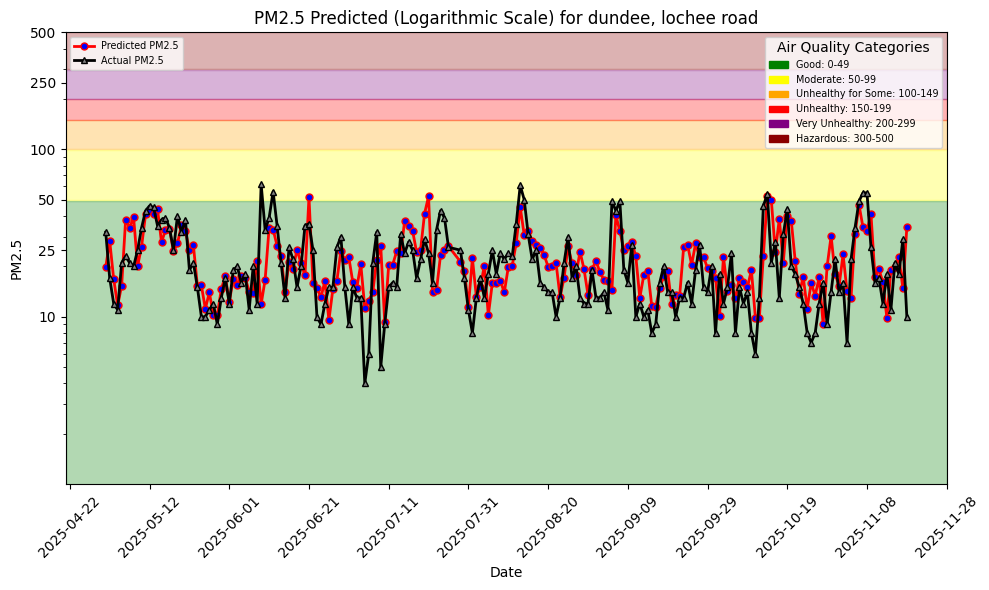

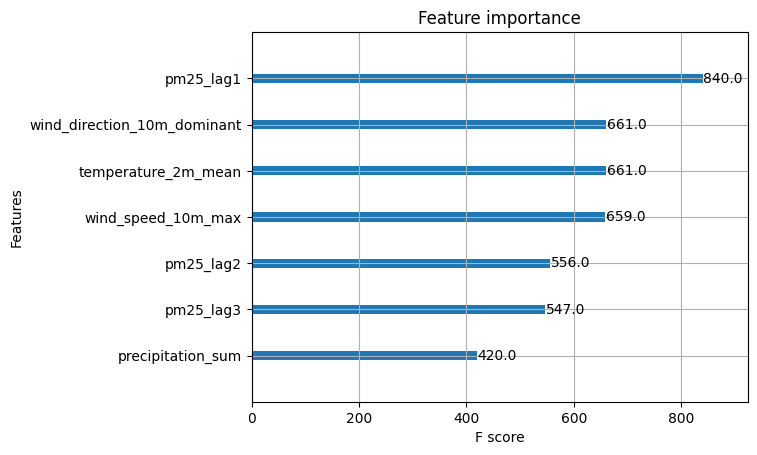

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_laglochee_road/model.json: 0…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_laglochee_road/images/pm25_h…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_laglochee_road/images/featur…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/model_schema.json: 0.000%|          | 0/782 el…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1296538/models/air_quality_xgboost_model_laglochee_road/1
{"country": "uk", "city": "dundee", "street": "whitehall street", "aqicn_url": "https://api.waqi.info/feed/@9579/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 22:31:02,609 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1296538/fs/1284171/fv/air_quality_fv_lag_whitehall_street/version/3
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 
Look if X_train_lag matches y_train_lag: 
                           date  pm25_lag1  pm25_lag2  pm25_lag3  \
0     2018-05-15 00:00:00+00:00       15.0       21.0       25.0   
1     2018-05-16 00:00:00+00:00       17.0       15.0       21.0

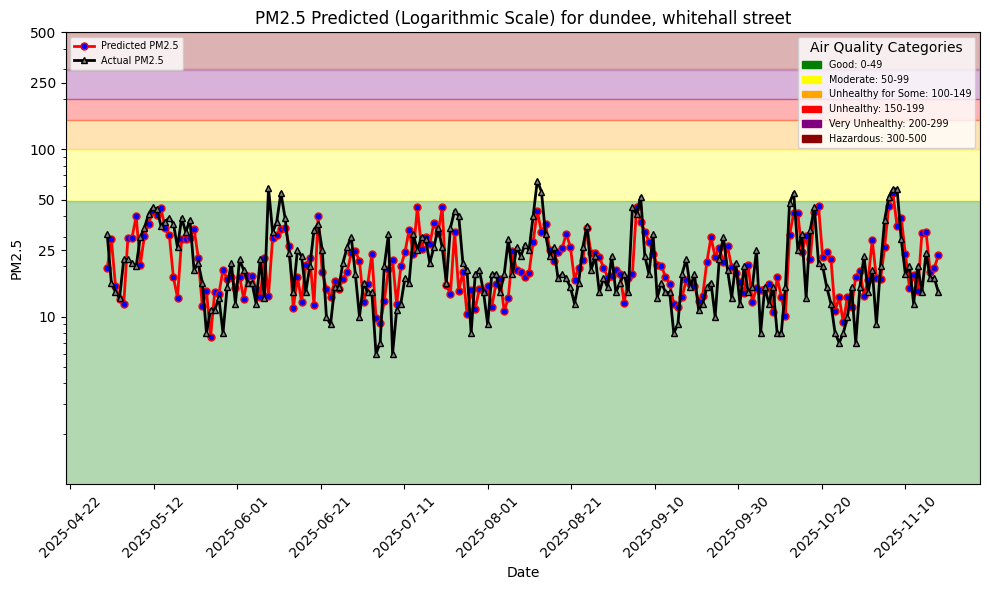

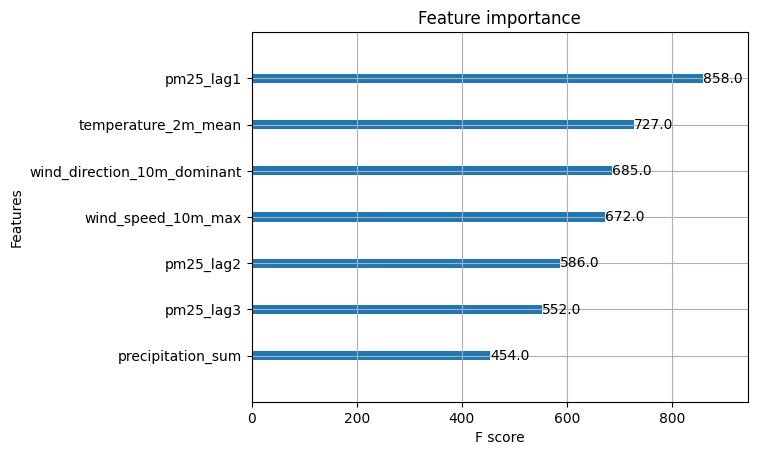

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagwhitehall_street/model.js…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagwhitehall_street/images/p…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagwhitehall_street/images/f…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/model_schema.json: 0.000%|          | 0/782 el…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1296538/models/air_quality_xgboost_model_lagwhitehall_street/1
{"country": "uk", "city": "dundee", "street": "meadowside", "aqicn_url": "https://api.waqi.info/feed/@5973/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 22:31:35,920 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1296538/fs/1284171/fv/air_quality_fv_lag_meadowside/version/3
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.49s) 
Look if X_train_lag matches y_train_lag: 
                           date  pm25_lag1  pm25_lag2  pm25_lag3  \
0     2018-05-14 00:00:00+00:00       21.0       28.0       60.0   
1     2018-05-15 00:00:00+00:00       15.0       21.0       28.0   
2  

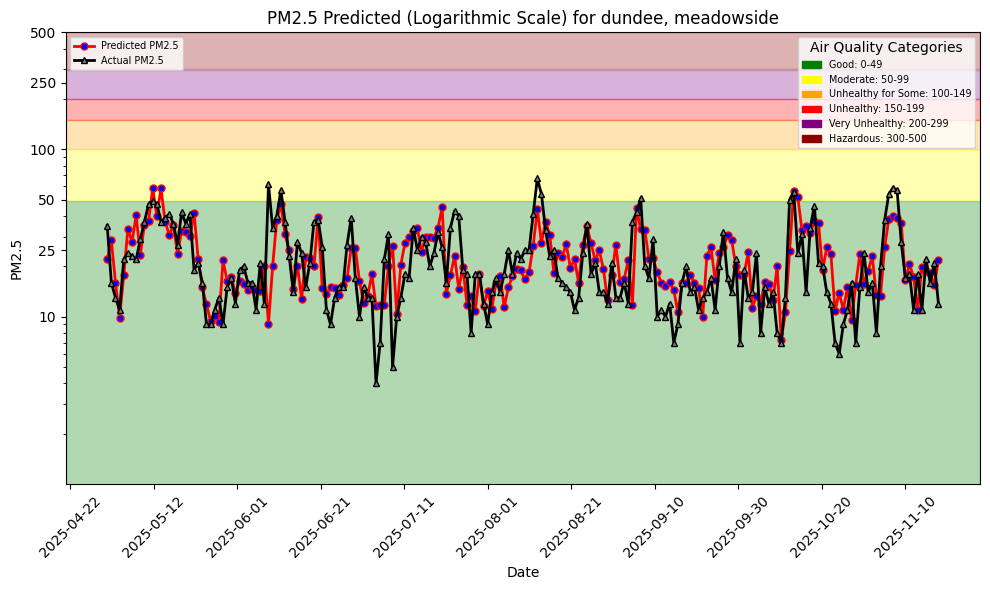

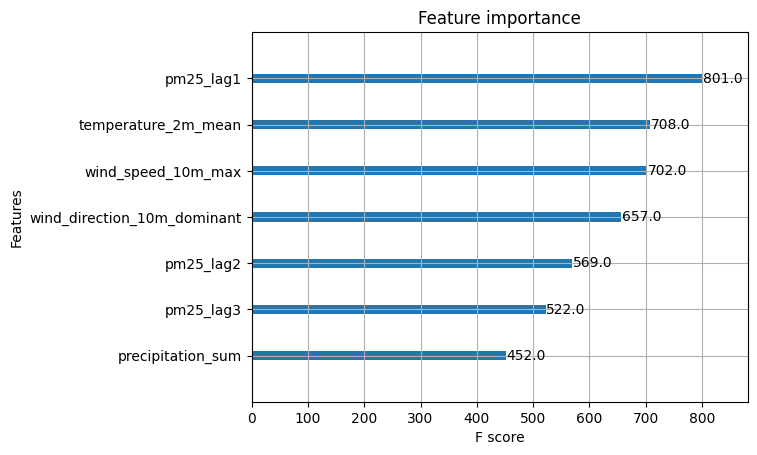

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagmeadowside/model.json: 0.…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagmeadowside/images/pm25_hi…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagmeadowside/images/feature…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/model_schema.json: 0.000%|          | 0/782 el…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1296538/models/air_quality_xgboost_model_lagmeadowside/1
{"country": "uk", "city": "dundee", "street": "seagate", "aqicn_url": "https://api.waqi.info/feed/@5974/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 22:32:11,477 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1296538/fs/1284171/fv/air_quality_fv_lag_seagate/version/3
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 
Look if X_train_lag matches y_train_lag: 
                           date  pm25_lag1  pm25_lag2  pm25_lag3  \
0     2018-05-18 00:00:00+00:00       20.0       17.0       17.0   
1     2018-05-19 00:00:00+00:00       28.0       20.0       17.0   
2     2018-05-2

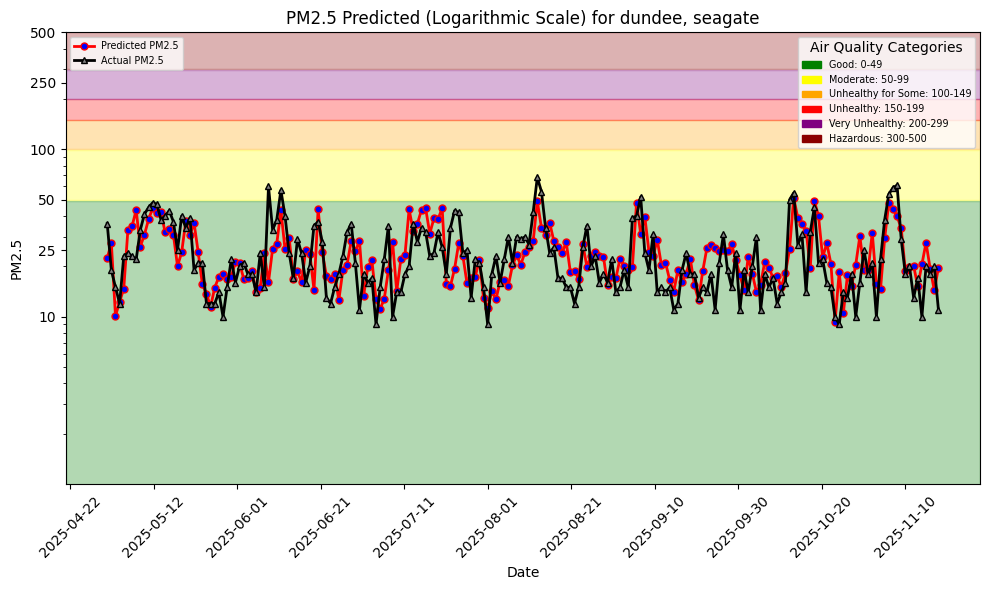

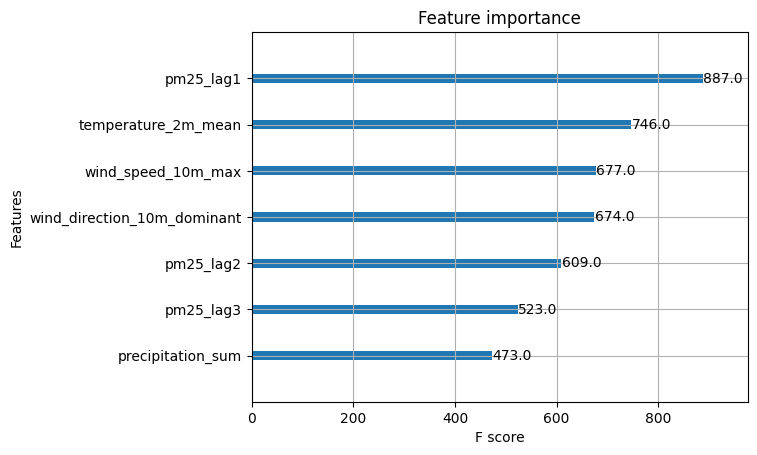

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagseagate/model.json: 0.000…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagseagate/images/pm25_hindc…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagseagate/images/feature_im…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/model_schema.json: 0.000%|          | 0/782 el…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1296538/models/air_quality_xgboost_model_lagseagate/1
{"country": "uk", "city": "dundee", "street": "mains loan", "aqicn_url": "https://api.waqi.info/feed/@5972/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 22:32:45,701 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1296538/fs/1284171/fv/air_quality_fv_lag_mains_loan/version/3
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 
Look if X_train_lag matches y_train_lag: 
                           date  pm25_lag1  pm25_lag2  pm25_lag3  \
0     2018-01-12 00:00:00+00:00       23.0       58.0       12.0   
1     2018-01-13 00:00:00+00:00       36.0       23.0       58.0   
2     2018-0

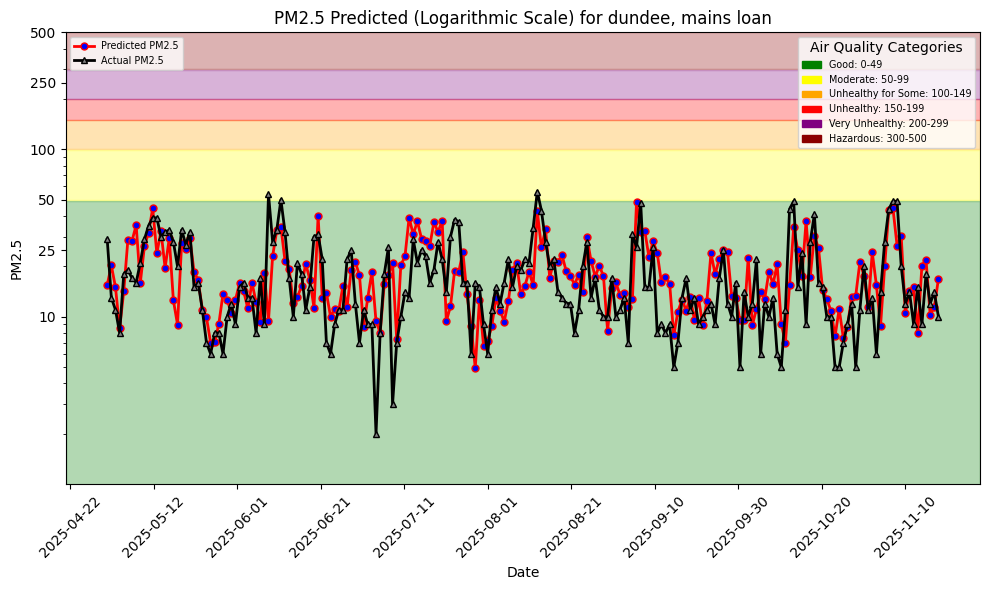

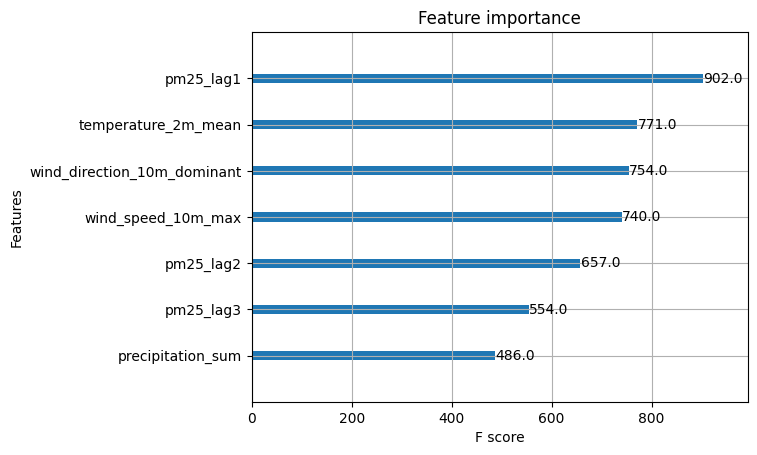

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagmains_loan/model.json: 0.…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagmains_loan/images/pm25_hi…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagmains_loan/images/feature…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/model_schema.json: 0.000%|          | 0/782 el…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1296538/models/air_quality_xgboost_model_lagmains_loan/1
{"country": "uk", "city": "dundee", "street": "broughty ferry road", "aqicn_url": "https://api.waqi.info/feed/@5970/", "latitude": 56.46, "longitude": -2.97}
2025-11-18 22:33:20,536 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1296538/fs/1284171/fv/air_quality_fv_lag_broughty_ferry_road/version/3
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.38s) 
Look if X_train_lag matches y_train_lag: 
                           date  pm25_lag1  pm25_lag2  pm25_lag3  \
0     2018-05-18 00:00:00+00:00       19.0       15.0       13.0   
1     2018-05-19 00:00:00+00:00       28.0       19.0      

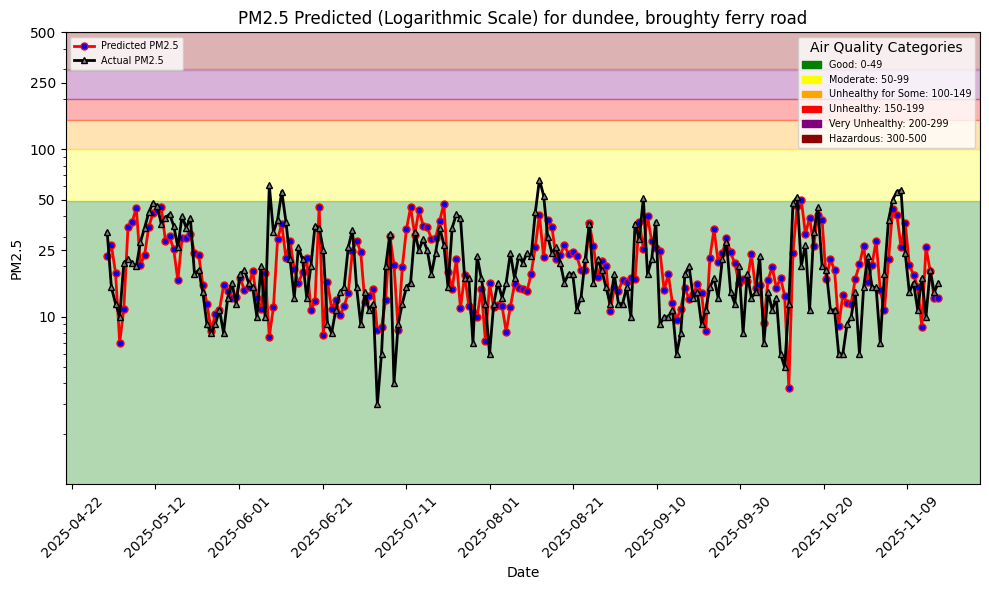

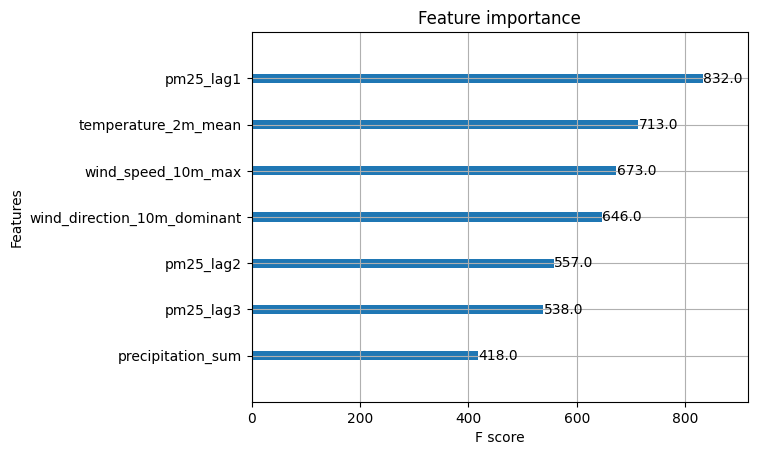

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagbroughty_ferry_road/model…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagbroughty_ferry_road/image…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/air_quality_model_lagbroughty_ferry_road/image…

Uploading /home/viktor/mlfs-book-a-version/notebooks/airquality/model_schema.json: 0.000%|          | 0/782 el…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1296538/models/air_quality_xgboost_model_lagbroughty_ferry_road/1
Finnished.


In [40]:
for sensor in SENSORS:
    street = sensor["street"]
    #Load the location!
    street_safe = street.replace(" ", "_").upper()
    secret_name = f"SENSOR_LOCATION_JSON_{street_safe}"
    location_str = secrets.get_secret(secret_name).value #location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    street=location['street']
    aqicn_url=location['aqicn_url']
    latitude=location['latitude']
    longitude=location['longitude']

    print(location_str)
    
    train_model(country, city, street, aqicn_url)

print("Finnished.")